In [226]:
import ehrapy as ep
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [227]:
import warnings
warnings.filterwarnings('ignore')
ep.settings.n_jobs=-1

df_a = pd.read_csv("notebooks/for_descriptives/icu_stay_diag_nocohort.csv.gz")
df_a['intime'] = pd.to_datetime(df_a['intime'], errors='coerce')
df_a['outtime'] = pd.to_datetime(df_a['outtime'], errors='coerce')
df_a['dod'] = pd.to_datetime(df_a['dod'], errors='coerce')

df_a = df_a.groupby('stay_id').head(1).reset_index(drop=True)

In [228]:

# should remove this earlier
#df_a.drop(["language", "religion", "marital_status"], inplace=True, axis=1)
# shift negative values for log_norm -> see #402 in ehrapy, do this after anndata creation!
# for neg_col in ["Base Excess_min", "Base Excess_max", "Base Excess_avg", "Excrement_avg", "Excrement_min", "Excrement_max"]:
#     abs_min = abs(df_a[neg_col].min())
#     df_a[neg_col] = df_a[neg_col] + abs_min

adata = ep.ad.df_to_anndata(df_a, columns_obs_only=["disease_type","disease_name","intime", "outtime", 
                 "subject_id", "hadm_id", "stay_id", "gender", "ethnicity", "insurance", "hospital_death", "dod", "icd_code"])

In [229]:
ep.ad.infer_feature_types(adata)

! Feature  was detected as categorical features stored numerically.Please verify and correct using `ep.ad.replace_feature_types` if necessary.
 Detected feature types for 
AnnData object with 94444 obs and 
2 vars
├── 📅 Date features
├── 📐 Numerical features
│   ├── Age
│   └── los
└── 🗂️ Categorical features


In [230]:
adata = ep.pp.encode(adata, encodings={"one-hot": ["gender", 'ethnicity', 'insurance','disease_name', 'disease_type','hospital_death']})

Finished one-hot encoding. -- 100%


In [231]:
ep.ad.infer_feature_types(adata)

! Feature  was detected as categorical features stored numerically.Please verify and correct using `ep.ad.replace_feature_types` if necessary.
 Detected feature types for 
AnnData object with 94444 obs and 
971 vars
├── 📅 Date features
├── 📐 Numerical features
│   ├── Age
│   └── los
└── 🗂️ Categorical features
    ├── disease_name (904 
    │   categories); one-hot 
    │   encoded
    ├── disease_type (20 
    │   categories); one-hot 
    │   encoded
    ├── ethnicity (33 categories);
    │   one-hot encoded
    ├── gender (2 categories); 
    │   one-hot encoded
    ├── hospital_death (2 
    │   categories); one-hot 
    │   encoded
    └── insurance (6 categories); 
        one-hot encoded


In [232]:
value_counts = adata.obs['disease_type'].value_counts()
custom_labels = {category: f"{category} (n={count})" for category, count in value_counts.items()}
adata.obs['disease_type_total'] = adata.obs['disease_type'].map(custom_labels)
ep.pp.knn_impute(adata, n_neighbors=20)
# encode categoricals and make a new adata obj w/the encoded vars & save to a layer
adata_enc = ep.pp.encode(adata, autodetect=True, encodings="one_hot_encoding")
adata_enc.layers["original_imputed"] = adata_enc.X.copy()
# log norm continuous
ep.pp.log_norm(adata_enc)
# knearest neighbors
ep.pp.neighbors(adata_enc)
# umap
ep.tl.umap(adata_enc)

Performing KNN impute ⠹
! Detected no columns that need to be encoded. Leaving passed AnnData object unchanged.


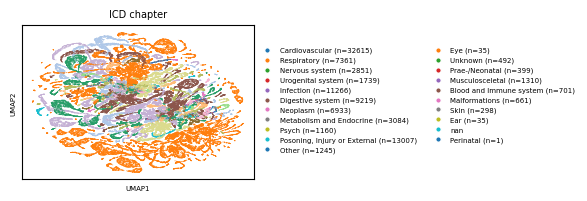

In [234]:
with plt.rc_context({"figure.figsize":(3,2)}):    
    fig = ep.pl.umap(adata_enc, color="disease_type_total", return_fig=True)   
    # Manually adjust the legend points' size
    legend_labels = pd.unique(adata.obs['disease_type_total'])
    legend_handles_1 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='C{}'.format(i), markersize=4) for i in range(len(legend_labels)//2)]
    legend_handles_2 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='C{}'.format(i), markersize=4) for i in range(len(legend_labels)//2, len(legend_labels))]

  # Create two separate sets of legend labels as strings
    legend_labels_1 = [str(label) for label in legend_labels[:len(legend_labels)//2]]
    legend_labels_2 = [str(label) for label in legend_labels[len(legend_labels)//2:]]

    # Flatten the lists of handles and labels
    all_handles = legend_handles_1 + legend_handles_2
    all_labels = legend_labels_1 + legend_labels_2

    plt.xlabel('UMAP1', fontsize=5, family='helvetica')
    plt.ylabel('UMAP2', fontsize=5, family='helvetica')
    plt.title('ICD chapter', fontsize=7, family='helvetica')
    legend_properties = {'family': 'helvetica', 'size': 5}
    legend = plt.legend(all_handles,all_labels, prop=legend_properties,loc='upper left', bbox_to_anchor=(1, .9), fancybox=False, ncol=2)
    legend.get_frame().set_edgecolor('none')
    legend.get_frame().set_linewidth(0)
    plt.savefig("fig3_disease_types_all.png", bbox_inches='tight', dpi=300)
    plt.show()

In [235]:
adata.var

,feature_type,unencoded_var_names,encoding_mode,missing_values_abs,missing_values_pct,mean,median,standard_deviation,min,max,iqr_outliers
ehrapycat_gender_F,categorical,gender,one-hot,0,0.000000,NaN,NaN,NaN,NaN,NaN,True
ehrapycat_gender_M,categorical,gender,one-hot,0,0.000000,NaN,NaN,NaN,NaN,NaN,True
ehrapycat_ethnicity_AMERICAN INDIAN/ALASKA NATIVE,categorical,ethnicity,one-hot,0,0.000000,NaN,NaN,NaN,NaN,NaN,True
ehrapycat_ethnicity_ASIAN,categorical,ethnicity,one-hot,0,0.000000,NaN,NaN,NaN,NaN,NaN,True
ehrapycat_ethnicity_ASIAN - ASIAN INDIAN,categorical,ethnicity,one-hot,0,0.000000,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...
ehrapycat_disease_type_nan,categorical,disease_type,one-hot,32,0.033883,NaN,NaN,NaN,NaN,NaN,True
ehrapycat_hospital_death_0,categorical,hospital_death,one-hot,0,0.000000,NaN,NaN,NaN,NaN,NaN,True
ehrapycat_hospital_death_1,categorical,hospital_death,one-hot,0,0.000000,NaN,NaN,NaN,NaN,NaN,True
Age,numeric,Age,NaN,0,0.000000,63.039780,65.000000,16.716262,18.00,91.000000,True


In [76]:
data = adata.to_df()
data.index = data.index.astype(int)

# ICD codes starting with J indicate respiratory diseases

In [236]:
df_b = pd.read_csv("notebooks/for_descriptives/icu_stay_diag_nocohort.csv.gz")
df_b['intime'] = pd.to_datetime(df_b['intime'], errors='coerce')
df_b['outtime'] = pd.to_datetime(df_b['outtime'], errors='coerce')
df_b['dod'] = pd.to_datetime(df_b['dod'], errors='coerce')

df_b = df_b.groupby('stay_id').head(1).reset_index(drop=True)


In [237]:
respiratory_diagnoses = df_b[
    df_b['icd_code'].fillna('').str.startswith('J')
]

In [238]:
respiratory_icd_codes = {"J00–J06": "Acute upper respiratory infections",
"J09–J19": "Influenza and pneumonia",
"J20–J23": "Other acute lower respiratory infections",
"J30–J39": "Other diseases of upper respiratory infections",
"J40–J48": "Chronic lower respiratory diseases",
"J60–J71": "Lung diseases due to external agents",
"J80–J84": "Other respiratory diseases principally affecting the interstitium",
"J85–J87": "Suppurative and necrotic conditions of the lower respiratory tract",
"J90–J94.9": "Other diseases of the pleura",
"J95–J95": "Intraoperative and postprocedural complications of respiratory system",
"J96–J99": "Other diseases of the respiratory system"}

def get_respiratory_category(value):
    for code_range, category in respiratory_icd_codes.items():
        start, end = code_range.split('–')
        if start <= value <= end:
            return category
    return None

respiratory_diagnoses['Respiratory Category'] = respiratory_diagnoses['icd_code'].apply(get_respiratory_category)

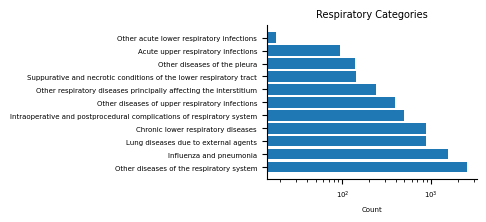

In [239]:
# Import the required libraries
import matplotlib.pyplot as plt

# Count the occurrences of each category
category_counts = respiratory_diagnoses['Respiratory Category'].value_counts()

with plt.rc_context({"figure.figsize":(3,2)}):        
    plt.barh(category_counts.index, category_counts.values)
    plt.xticks(fontsize=5, family="helvetica")
    plt.yticks(rotation=0, ha='right', fontsize=5, family="helvetica")
    plt.xlabel('Count', fontsize=5, family='helvetica')
    plt.title('Respiratory Categories', fontsize=7, family='helvetica')
    plt.xscale('log')

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.rcParams['font.family'] = 'helvetica'
    plt.subplots_adjust(left=0.2)

    plt.savefig("fig3_respiratory_subtypes.png", bbox_inches='tight', dpi=300)  # save first
    plt.show()  # display after saving



# Part B

In [240]:
df_c = df_b.loc[df_b.disease_type == "Respiratory"]
# focus on J10–J19": "Influenza and pneumonia"
respiratory_diagnoses = respiratory_diagnoses.loc[respiratory_diagnoses["Respiratory Category"] == "Influenza and pneumonia"]
pneumonia_influenza_df = df_c[df_c['hadm_id'].isin(respiratory_diagnoses['hadm_id'])]

In [207]:
# remove some patients with diseases falsely assigned into the pneumonia and influenza category (most likely due to an annotation failure during the dataset generation)
##exclude_diagnoses = ["Pneumothorax, unspecified", "Emphysema, unspecified", "Pulmonary collapse"]
#pneumonia_influenza_df = pneumonia_influenza_df[~pneumonia_influenza_df['disease_name'].isin(exclude_diagnoses)]

In [241]:
adata = ep.ad.df_to_anndata(pneumonia_influenza_df, columns_obs_only=["disease_type","disease_name","intime", "outtime", 
                 "subject_id", "hadm_id", "stay_id", "gender", "ethnicity", "insurance", "hospital_death", "dod", "icd_code"])

In [242]:
ep.ad.infer_feature_types(adata)

! Feature  was detected as categorical features stored numerically.Please verify and correct using `ep.ad.replace_feature_types` if necessary.
 Detected feature types for 
AnnData object with 1533 obs and 2
vars
├── 📅 Date features
├── 📐 Numerical features
│   ├── Age
│   └── los
└── 🗂️ Categorical features


In [243]:
adata = ep.pp.encode(adata, encodings={"one-hot": ["gender", 'ethnicity', 'insurance','disease_name', 'disease_type','hospital_death']})

Finished one-hot encoding. -- 100%


In [244]:
value_counts = adata.obs['disease_name'].value_counts()
custom_labels = {category: f"{category} (n={count})" for category, count in value_counts.items()}
adata.obs['disease_name_total'] = adata.obs['disease_name'].map(custom_labels)

ep.pp.knn_impute(adata, n_neighbors=5)
adata_enc = ep.pp.encode(adata, autodetect=True, encodings="one_hot_encoding")
adata_enc.layers["original_imputed"] = adata_enc.X.copy()
ep.pp.log_norm(adata_enc)
ep.pp.neighbors(adata_enc)
ep.tl.umap(adata_enc)

Performing KNN impute ⠋
! Detected no columns that need to be encoded. Leaving passed AnnData object unchanged.


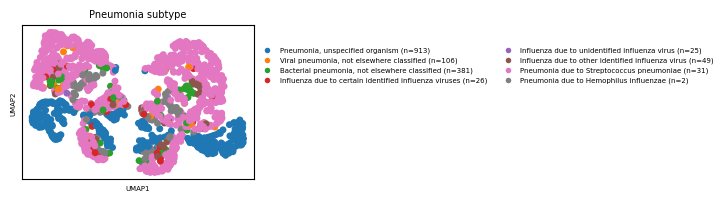

In [246]:
with plt.rc_context({"figure.figsize": (3, 2)}):    
    fig = ep.pl.umap(adata_enc, color="disease_name_total", title="Pneumonia subtype", size=100, return_fig=True)

    # Adjust the legend size manually
    legend_labels = pd.unique(adata.obs['disease_name_total'])
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=f'C{i}', markersize=5)
        for i in range(len(legend_labels))
    ]

    plt.xlabel('UMAP1', fontsize=5, family='helvetica')
    plt.ylabel('UMAP2', fontsize=5, family='helvetica')
    plt.title('Pneumonia subtype', fontsize=7, family='helvetica')

    legend_properties = {'family': 'helvetica', 'size': 5}
    plt.legend(legend_handles, legend_labels, prop=legend_properties, loc='upper left', 
               bbox_to_anchor=(1, 0.9), fancybox=True, ncol=2, frameon=False)

    plt.tight_layout()
    plt.savefig("fig3_pneumonia_subtype.png", bbox_inches='tight', dpi=300)
    plt.show()

# Part C